### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

### Таргеты

1.   MSE : $-\frac{dL}{da(x_i)}(L(a(x_i), y_i)) = 2 (y_i - a(x_i))$
2.   Экспоненциальная : $-\frac{dL}{da(x_i)}(L(a(x_i), y_i)) = exp(-a(x_i)y_i)y_i$
3.   Логистическая : $-\frac{dL}{da(x_i)}(L(a(x_i), y_i)) = \frac{y_i}{exp(a(x_i)y_i) + 1}$



##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
from math import exp
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tqdm import tqdm

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.models = []
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """

        # 1 шаг: инициализировать f_0
        # 2 шаг: обучить f_k на выборке (x_i, -dL/dF) на MSE функции потерь. Посчитать антиградиент
        # 3 шаг: найти шаг c_k. В нашем случае это self.learning_rate
        # 4 шаг: достроить ансамбль F_k = F_k-1 + c_k*f_k
        # 5 шаг: повторять 2-4 M итераций

        '''
        Должна быть поддержка colsample и subsample!
        X.sample(frac=...)
        Вот хочется так написать, но тогда мы ничего не сможем сделать с y.
        Поэтому буду использовать механизм масок
        '''
        mask_x = np.zeros(X.shape[0]).astype(bool)
        mask_x[:round(X.shape[0]*self.subsample)] = True
        np.random.shuffle(mask_x)

        mask_y = np.zeros(X.shape[1]).astype(bool)
        mask_y[:round(X.shape[1]*self.colsample)] = True
        np.random.shuffle(mask_y)
        
        #X = X[mask_x][:,mask_y]
        #y = y[mask_x]
        #---1---
        if init_model == None:
            model = None
        else:
            init_ = init_model(*self.args, **self.kwargs)
            model = init_.fit(X, y)
        
        self.models.append(model)

        #---2--- 
        for i in range(self.n_estimators - 1):  # 1 модель считаем вручную
            model = base_model(*self.args, **self.kwargs)
            if self.loss == 'mse':
                model.fit(X[mask_x][:,mask_y], 2*(y[mask_x] - self.predict(X[mask_x])))
            elif self.loss == 'exp':
                model.fit(X[mask_x][:,mask_y], np.exp(-self.predict(X[mask_x])*y[mask_x])*y[mask_x])
            elif self.loss == 'log':
                model.fit(X[mask_x][:,mask_y], y[mask_x]/(np.exp(self.predict(X[mask_x])*y[mask_x])+1))
            self.models.append([model, mask_y])  # 4 шаг
            

        
    def predict(self, X):
        answer = np.zeros(len(X))
        first_flag = True
        for i in self.models:
            if first_flag:
                if i != None:
                    answer += i.predict(X[:])
                first_flag = False
            else:
                answer += self.learning_rate * i[0].predict(X[:, i[1]]) 
        return np.rint(answer).astype(int)




In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

100%|██████████| 20/20 [02:31<00:00,  7.59s/it]


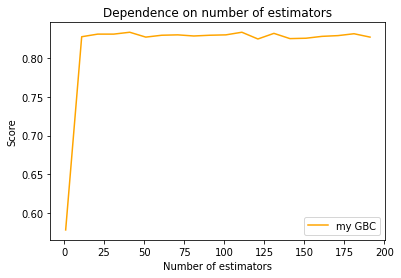

In [9]:
my_GBC_score = []
number_of_estimators = []
for i in tqdm(range(1, 200, 10)):
    my_clf = MyGradientBoostingClassifier(n_estimators = i)
    my_clf.fit(X_train, y_train)
    my_GBC_score.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    number_of_estimators.append(i)


plt.plot(number_of_estimators, my_GBC_score, color='orange', label='my GBC')

plt.xlabel("Number of estimators")
plt.ylabel("Score")
plt.title("Dependence on number of estimators")

plt.legend()
plt.show()

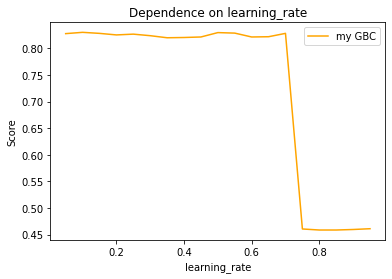

In [12]:
my_GBC_score = []
number_of_estimators = []
for i in (np.arange(0.05, 1.0, 0.05)):
    my_clf = MyGradientBoostingClassifier(learning_rate=i)
    my_clf.fit(X_train, y_train)
    my_GBC_score.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    number_of_estimators.append(i)


plt.plot(number_of_estimators, my_GBC_score, color='orange', label='my GBC')

plt.xlabel("learning_rate")
plt.ylabel("Score")
plt.title("Dependence on learning_rate")

plt.legend()
plt.show()

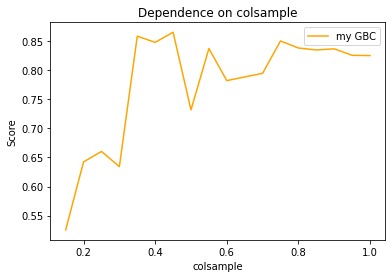

In [13]:
my_GBC_score = []
number_of_estimators = []
for i in (np.arange(0.15, 1.05, 0.05)):
    my_clf = MyGradientBoostingClassifier(colsample=i)
    my_clf.fit(X_train, y_train)
    my_GBC_score.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    number_of_estimators.append(i)


plt.plot(number_of_estimators, my_GBC_score, color='orange', label='my GBC')

plt.xlabel("colsample")
plt.ylabel("Score")
plt.title("Dependence on colsample")

plt.legend()
plt.show()

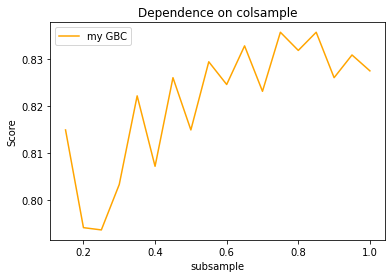

In [14]:
my_GBC_score = []
number_of_estimators = []
for i in (np.arange(0.15, 1.05, 0.05)):
    my_clf = MyGradientBoostingClassifier(subsample=i)
    my_clf.fit(X_train, y_train)
    my_GBC_score.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    number_of_estimators.append(i)


plt.plot(number_of_estimators, my_GBC_score, color='orange', label='my GBC')

plt.xlabel("subsample")
plt.ylabel("Score")
plt.title("Dependence on subsample")

plt.legend()
plt.show()

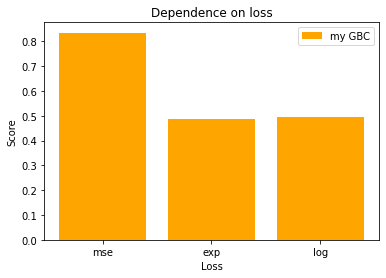

In [15]:
my_loss = ['mse', 'exp', 'log']
my_GBC_score = []
for i in my_loss:
    my_clf = MyGradientBoostingClassifier(loss=i)
    my_clf.fit(X_train, y_train)
    my_GBC_score.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

plt.bar(my_loss, my_GBC_score, color='orange', label='my GBC')

plt.xlabel("Loss")
plt.ylabel("Score")
plt.title("Dependence on loss")

plt.legend()
plt.show()

### Таким образом выяснили, что самые оптимальные признаки это: 

*   loss='mse'
*   n_estimators=100 (здесь не принципиально)
*   learning_rate=0.7
*   colsample=0.45
*   subsample=0.85






In [20]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.7, colsample=0.45, subsample=0.85)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.6908914728682171


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [17]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.7, colsample=0.55, subsample=0.95)
my_clf.fit(X=X_train, y=y_train, init_model=LinearRegression)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.6472868217054264


In [18]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.7, colsample=0.55, subsample=0.95)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.875484496124031


In [19]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.7, colsample=0.55, subsample=0.95)
my_clf.fit(X_train, y_train, init_model=SVR)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.41908914728682173


### Качество немного подросло в RandomForestRegressor. Всё-равно инициализация нулями это не всегда хорошо. При умной инициализации можно найти другие зависимости.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Всё-таки тяжеловато. Вроде и лекцию посмотрел и презентацию заботал, а всё-равно идёт туго. Особенно с методом fit долго просидел. Может стоит дать подсказку как его делать в следующий раз. Хорошо, что времени было предостаточно. 
Ещё с colsample и subsample провозился. Куча ошибок с размерностью было, но вроде всё пофиксил. Времени убил кончено...

Ещё не очень круто, что дедлайн тесно пересекается с соревнованием и мини-проектом по анализу. Поэтому пришлось на майских прям посидеть.

А в целом прикольное дз, считай возишься 80% времени с построением класса, а потом просто чиллишь на подборе параметров. Имхо, самая интересная домашка)

### ВАШ ОТЗЫВ ЗДЕСЬ

